In [ ]:
# импорт необходимых данных
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import t
from scipy.signal import find_peaks
from statsmodels.stats.stattools import durbin_watson

# формат вывода данных 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#проверка аномалий по Ирвину
def anomaly_check(data):
  mean = data.mean()
  variance = data.var()
  std = sqrt(variance)
  irvin_column = (data - mean)**2
  s = abs(data.diff())
  tf = s/std <= 1.0
  info = {'Months':df_poland['Months'],'Irvin':s/std,'No anomaly':tf}
  df_info = pd.DataFrame(info)
  print(df_info)

#функция простой скользящей средней, окно = 3
def smoothing(data_frame,y_label):
  from pandas import Series
  series = Series(data=data_frame)
  #Tail-rolling average transform
  rolling = series.rolling(window=3)
  rolling_mean = rolling.mean()
  plt.xlabel("Months") # ось абсцисс
  plt.ylabel(y_label) # ось ординат
  plt.grid()      # включение отображения сетки
  # plot original and transformed dataset
  plt.plot(df_poland['Months'],series)
  plt.plot(df_poland['Months'],rolling_mean,color='red')
  plt.show()
  return(pd.DataFrame({str(y_label):rolling_mean.values}))

def autocorr_lags(label):
  df_correl1 = df_poland[str(label)].squeeze().autocorr(lag=1)
  df_correl2 = df_poland[str(label)].squeeze().autocorr(lag=2)
  df_correl3 = df_poland[str(label)].squeeze().autocorr(lag=3)
  corr_array = np.array([df_correl1,df_correl2,df_correl3])
  df_corr = pd.DataFrame({'corr':corr_array})
  print("Коэффициенты автокорреляции: ", corr_array)
  fig, ax = plt.subplots()
  x = [1,2,3]
  ax.bar(x, corr_array)
  return (corr_array)

def t_stat(data):
  x = np.zeros(shape=np.shape(data))
  x[:]=len(data)
  result = np.sqrt((np.square(data)/(np.ones(shape=np.shape(data))-np.square(data)))*len(df_poland.index)-2)
  result_crit = t.ppf(1-0.025, len(df_poland.index)-2)
  print("Критическое значение:", result_crit)
  print("Статистические значения коэффициента корреляции: ", result)
  print("Коэффициенты, удовлетворяющие условию: ", result>result_crit)

#Gauss Markov
def non_biased(remainders):
  t_value = abs((remainders.mean()/remainders.std())*len(remainders))
  result_crit = t.ppf(1-0.025, len(remainders)-2)
  if (t_value<result_crit)==True:
    return("Шум несмещён, условие выполнено", 'T и крит', t_value,result_crit)
  else:
    return("Шум смещён, условие не выполнено")

def randmonless(remainders):
  remainders = remainders.ravel()
  peaks = find_peaks(remainders)
  peaks_sum = len(peaks[0])
  peaks_crit = int((2/3)*(len(remainders)-2)-1.96*math.sqrt((16*len(remainders)-29)/90))
  print('Крит и сумм пиков', peaks_crit,peaks_sum)
  if (peaks_sum<peaks_crit)==True:
    return("Шумы неслучайны, условие не выполнено")
  else:
    return("Шумы случайны, условие выполнено")

def autocorrel_noise(remainders):
  df_data = pd.DataFrame({'col1':remainders.ravel()})
  df_correl = df_data['col1'].squeeze().autocorr(lag=1)
  return(df_correl)

def independent_darbin(remainders):
  remainders1 = remainders
  remainders = remainders.ravel()
  remainders_diff = (np.ediff1d(remainders)**2).sum()/(remainders**2).sum()
  darbin_watson_1 = 1.54
  darbin_watson_2 = 1.78
  if (remainders_diff>2):
    remainders_diff_1=4-remainders_diff
  if ((remainders_diff>0)&(remainders_diff<darbin_watson_1)):
    return("Eсть положительная автокорреляция остатков,"+" Коэффициент автокорреляции (1): "+str(autocorrel_noise(remainders1))+"\n"+ str(remainders_diff))
  if ((remainders_diff_1>0)&(remainders_diff_1<darbin_watson_1)):
    return("Eсть отрицательная автокорреляция остатков,"+" Коэффициент автокорреляции (1): "+str(autocorrel_noise(remainders1))+"\n"+ str(remainders_diff))
  if (((remainders_diff>darbin_watson_1)&(remainders_diff<darbin_watson_2))|((remainders_diff_1>darbin_watson_1)&(remainders_diff_1<darbin_watson_2))):
    return("Облать неопределённости, нужен другой критерий")
  if (((remainders_diff>darbin_watson_2)&(remainders_diff<2))|((remainders_diff_1>darbin_watson_2)&(remainders_diff_1<2))):
    return("Автокорреляции нет" +"\n"+ str(remainders_diff))

def normality(remainders):
  rs_crit_1=3.47
  rs_crit_2=4.89
  rs = (max(remainders)-min(remainders))/remainders.std()
  print('RS', rs)
  if (rs>rs_crit_1)&(rs<rs_crit_2):
    return("Шум нормальный, т.е. у шумов нормальное распределение")
  else:
    return("У шумов не нормальное распределение")

def model_accuracy(remainders,row):
  remainders = remainders.ravel()
  row = row.ravel()
  mean_absolute_accuracy=abs(remainders).mean()
  relative_accuracy=(((abs(remainders)/abs(row))).mean())*100
  relative_mean_accuracy=(mean_absolute_accuracy)/(abs(row).mean())*100
  std_accuracy=(mean_absolute_accuracy)/(abs(row).std())*100
  print("Средняя абсолютная ошибка",round(mean_absolute_accuracy,2))
  print("Относительная ошибка(%)",round(relative_accuracy,2))
  print("Относительная ошибка по среднему(%)",round(relative_mean_accuracy,2))
  print("Относительная ошибка по СКО(%)",round(std_accuracy,2))

def f_crit(r,m,n):
  f_crit = 3.88312 # FРАСПОБР из Excel по 227-2 степеням
  f_th = (r/(1-r))*((n-m-1)/m)
  if f_th>f_crit:
    print('Коэффициент детерминации статистически значим')
  else:
    print('Коэффициент детерминации статистически не значим')

def left_right_edge(t_num,remainders,k):
  s = math.sqrt((1/(len(remainders)-1))*np.sum(remainders**2))
  result_crit = t.ppf(1-0.025, len(remainders)-1)
  u_k_1 = ((len(remainders)+k-df_poland['Months'].mean())**2)/(((df_poland['Months']-df_poland['Months'].mean())**2).sum())
  u_k = s*result_crit*math.sqrt(1+(1/len(remainders))+u_k_1)
  return u_k

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df_poland = pd.read_csv('dataPL.csv', sep=",", decimal='.')

     Months    Irvin  No anomaly
0         0      NaN       False
1         1  0.36780        True
2         2  0.22068        True
3         3  0.14712        True
4         4  0.36780        True
5         5  0.07356        True
6         6  0.44136        True
7         7  0.14712        True
8         8  0.51492        True
9         9  0.14712        True
10       10  0.14712        True
11       11  0.14712        True
12       12  0.29424        True
13       13  0.07356        True
14       14  0.22068        True
15       15  0.07356        True
16       16  0.66204        True
17       17  0.07356        True
18       18  0.14712        True
19       19  0.07356        True
20       20  0.07356        True
21       21  0.36780        True
22       22  0.14712        True
23       23  0.14712        True
24       24  0.29424        True
25       25  0.14712        True
26       26  0.00000        True
27       27  0.14712        True
28       28  0.00000        True
29       2

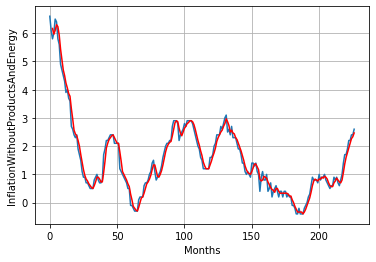

In [ ]:
# график зависимости инфляции от месяцев + сглаживание
from math import sqrt
anomaly_check(df_poland['InflationWithoutProductsAndEnergy'])
smoothed_data=smoothing(df_poland['InflationWithoutProductsAndEnergy'],'InflationWithoutProductsAndEnergy')
df_poland['InflationWithoutProductsAndEnergy']=smoothed_data['InflationWithoutProductsAndEnergy']

     Months         Irvin  No anomaly
0         0           NaN       False
1         1           NaN       False
2         2           NaN       False
3         3  1.522697e-01        True
4         4  1.015131e-01        True
5         5  1.522697e-01        True
6         6  5.075656e-02        True
7         7  2.284045e-01        True
8         8  3.806742e-01        True
9         9  2.791611e-01        True
10       10  2.791611e-01        True
11       11  1.522697e-01        True
12       12  2.030262e-01        True
13       13  1.268914e-01        True
14       14  1.522697e-01        True
15       15  7.613484e-02        True
16       16  3.299176e-01        True
17       17  2.791611e-01        True
18       18  3.045394e-01        True
19       19  1.015131e-01        True
20       20  5.075656e-02        True
21       21  1.268914e-01        True
22       22  1.522697e-01        True
23       23  2.284045e-01        True
24       24  2.030262e-01        True
25       25 

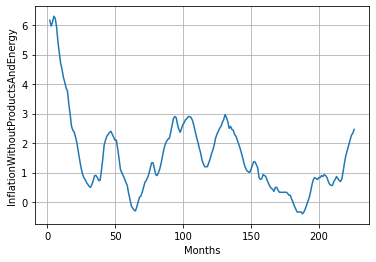

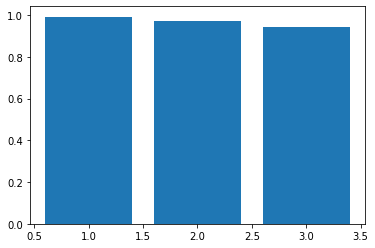

In [ ]:
# график зависимости инфляции от месяцев + аномалии + автокорреляция
plt.xlabel("Months") # ось абсцисс
plt.ylabel("InflationWithoutProductsAndEnergy") # ось ординат
plt.grid()      # включение отображения сетки
plt.plot(df_poland['Months'],df_poland['InflationWithoutProductsAndEnergy'])
anomaly_check(df_poland['InflationWithoutProductsAndEnergy'])
corr_data = autocorr_lags('InflationWithoutProductsAndEnergy')
print(t_stat(corr_data))

     Months     Irvin  No anomaly
0         0       NaN       False
1         1  0.427244        True
2         2  0.230268        True
3         3  0.235261        True
4         4  0.169233        True
5         5  0.398391        True
6         6  0.580386        True
7         7  0.052712        True
8         8  0.417811        True
9         9  0.183104        True
10       10  0.219725        True
11       11  0.029963        True
12       12  0.075461        True
13       13  0.028853        True
14       14  0.114302        True
15       15  0.138161        True
16       16  0.634762        True
17       17  0.171452        True
18       18  0.146484        True
19       19  0.034401        True
20       20  0.036621        True
21       21  0.110418        True
22       22  0.110972        True
23       23  0.055486        True
24       24  0.166459        True
25       25  0.000000        True
26       26  0.055486        True
27       27  0.166459        True
28       28  0

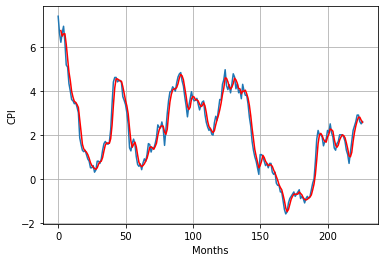

In [ ]:
# график зависимости ключевой ставки от месяцев + сглаживание
from math import sqrt
anomaly_check(df_poland['CPI'])
smoothed_data=smoothing(df_poland['CPI'],'CPI')
df_poland['CPI']=smoothed_data['CPI']

     Months         Irvin  No anomaly
0         0           NaN       False
1         1           NaN       False
2         2           NaN       False
3         3  1.442260e-01        True
4         4  5.950980e-02        True
5         5  2.084738e-03        True
6         6  2.765121e-01        True
7         7  3.523208e-01        True
8         8  3.589540e-01        True
9         9  2.232565e-01        True
10       10  2.803025e-01        True
11       11  1.478269e-01        True
12       12  1.110597e-01        True
13       13  2.615399e-02        True
14       14  5.496128e-02        True
15       15  7.637723e-02        True
16       16  3.030451e-01        True
17       17  3.225659e-01        True
18       18  3.254087e-01        True
19       19  1.203463e-01        True
20       20  4.927563e-02        True
21       21  3.695672e-02        True
22       22  6.311071e-02        True
23       23  9.457131e-02        True
24       24  1.137130e-01        True
25       25 

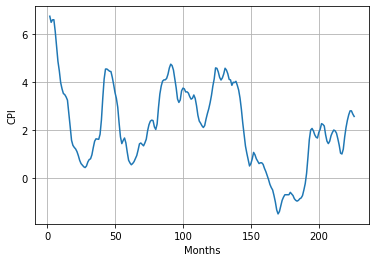

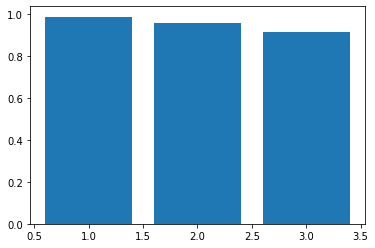

In [ ]:
# график зависимости ключевой ставки от месяцев + аномалии + автокорреляция
plt.xlabel("Months") # ось абсцисс
plt.ylabel("CPI") # ось ординат
plt.grid()      # включение отображения сетки
plt.plot(df_poland['Months'],df_poland['CPI'])
anomaly_check(df_poland['CPI'])
corr_array = autocorr_lags('CPI')
print(t_stat(corr_array))

     Months     Irvin  No anomaly
0         0       NaN       False
1         1  1.611183       False
2         2  0.496907        True
3         3  0.075289        True
4         4  0.632427        True
5         5  0.647485        True
6         6  0.933583        True
7         7  0.090347        True
8         8  0.692658        True
9         9  0.828178        True
10       10  0.421618        True
11       11  0.572196        True
12       12  0.511965        True
13       13  0.240925        True
14       14  0.496907        True
15       15  0.511965        True
16       16  0.677601        True
17       17  0.948641        True
18       18  0.542080        True
19       19  1.023930       False
20       20  1.159450       False
21       21  0.511965        True
22       22  0.015058        True
23       23  0.316214        True
24       24  0.094451        True
25       25  0.216274        True
26       26  0.230920        True
27       27  0.329748        True
28       28  0

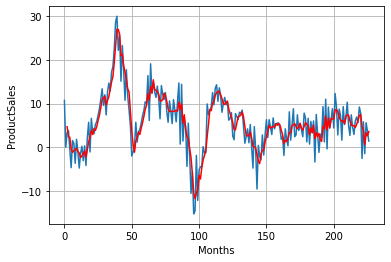

In [ ]:
# график зависимости объема продаж продукта от месяцев + сглаживание
from math import sqrt
anomaly_check(df_poland['ProductSales'])
smoothed_data=smoothing(df_poland['ProductSales'],'ProductSales')
df_poland['ProductSales']=smoothed_data['ProductSales']

     Months         Irvin  No anomaly
0         0           NaN       False
1         1           NaN       False
2         2           NaN       False
3         3  3.835954e-01        True
4         4  2.223742e-02        True
5         5  4.447483e-01        True
6         6  1.278651e-01        True
7         7  7.227160e-02        True
8         8  5.559354e-02        True
9         9  1.667806e-02        True
10       10  1.056277e-01        True
11       11  6.115290e-02        True
12       12  1.778993e-01        True
13       13  6.671225e-02        True
14       14  9.450902e-02        True
15       15  9.450902e-02        True
16       16  2.446116e-01        True
17       17  2.890864e-01        True
18       18  3.002051e-01        True
19       19  1.723400e-01        True
20       20  2.501709e-01        True
21       21  1.389839e-01        True
22       22  2.334929e-01        True
23       23  7.783096e-02        True
24       24  1.460583e-01        True
25       25 

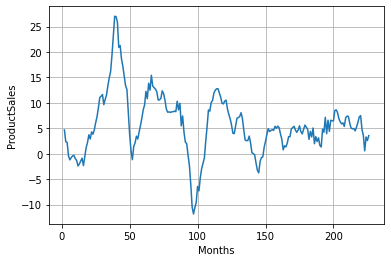

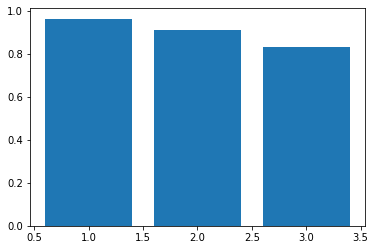

In [ ]:
# график зависимости объема продаж продукта от месяцев + аномалии + автокорреляция
plt.xlabel("Months") # ось абсцисс
plt.ylabel("ProductSales") # ось ординат
plt.grid()      # включение отображения сетки
plt.plot(df_poland['Months'],df_poland['ProductSales'])
anomaly_check(df_poland['ProductSales'])
corr_array = autocorr_lags('ProductSales')
print(t_stat(corr_array))

     Months     Irvin  No anomaly
0         0       NaN       False
1         1  0.214679        True
2         2  0.107339        True
3         3  0.143119        True
4         4  0.393577        True
5         5  0.500917        True
6         6  0.107339        True
7         7  0.143119        True
8         8  0.107339        True
9         9  0.429357        True
10       10  0.178899        True
11       11  0.214679        True
12       12  0.143119        True
13       13  0.071560        True
14       14  0.035780        True
15       15  0.035780        True
16       16  0.035780        True
17       17  0.250458        True
18       18  0.178899        True
19       19  0.143119        True
20       20  0.071560        True
21       21  0.214679        True
22       22  0.000000        True
23       23  0.178899        True
24       24  0.107339        True
25       25  0.500917        True
26       26  0.107339        True
27       27  0.322018        True
28       28  0

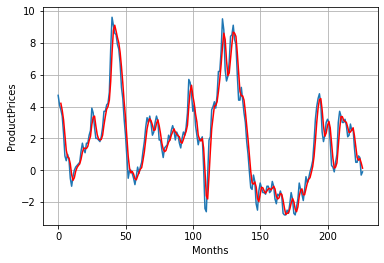

In [ ]:
# график зависимости цен продукта от месяцев + сглаживание
from math import sqrt
anomaly_check(df_poland['ProductPrices'])
smoothed_data=smoothing(df_poland['ProductPrices'],'ProductPrices')
df_poland['ProductPrices']=smoothed_data['ProductPrices']

     Months         Irvin  No anomaly
0         0           NaN       False
1         1           NaN       False
2         2           NaN       False
3         3  1.585389e-01        True
4         4  2.195153e-01        True
5         5  3.536636e-01        True
6         6  3.414683e-01        True
7         7  1.585389e-01        True
8         8  2.439059e-02        True
9         9  1.341483e-01        True
10       10  2.439059e-01        True
11       11  1.341483e-01        True
12       12  6.097648e-02        True
13       13  1.463436e-01        True
14       14  8.536707e-02        True
15       15  4.878119e-02        True
16       16  3.658589e-02        True
17       17  1.097577e-01        True
18       18  1.585389e-01        True
19       19  9.756237e-02        True
20       20  1.219530e-02        True
21       21  0.000000e+00        True
22       22  4.878119e-02        True
23       23  1.341483e-01        True
24       24  9.756237e-02        True
25       25 

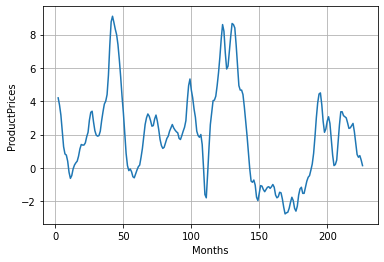

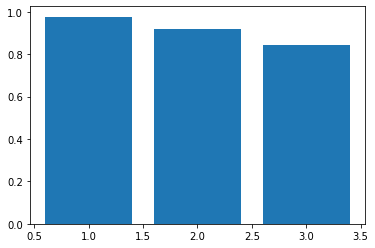

In [ ]:
# график зависимости цен продукта от месяцев + аномалии + автокорреляция
plt.xlabel("Months") # ось абсцисс
plt.ylabel("ProductPrices") # ось ординат
plt.grid()      # включение отображения сетки
plt.plot(df_poland['Months'],df_poland['ProductPrices'])
anomaly_check(df_poland['ProductPrices'])
corr_array = autocorr_lags('ProductPrices')
print(t_stat(corr_array))

     Months     Irvin  No anomaly
0         0       NaN       False
1         1  0.874735        True
2         2  0.056818        True
3         3  1.044158       False
4         4  1.424915       False
5         5  1.578861       False
6         6  1.252136       False
7         7  0.444372        True
8         8  0.276730        True
9         9  0.653208        True
10       10  0.500597        True
11       11  0.514989        True
12       12  0.178344        True
13       13  0.087277        True
14       14  0.281804        True
15       15  0.974899        True
16       16  0.748169        True
17       17  0.132047        True
18       18  0.087428        True
19       19  0.540305        True
20       20  0.418335        True
21       21  1.313832       False
22       22  0.510194        True
23       23  0.228713        True
24       24  0.130603        True
25       25  0.224628        True
26       26  0.570326        True
27       27  1.409043       False
28       28  1

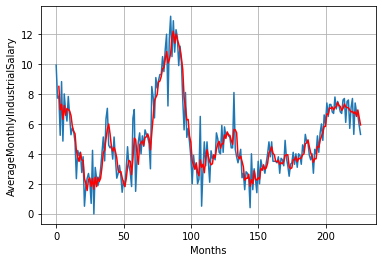

In [ ]:
# график зависимости средней зарплаты на производстве от месяцев + сглаживание
from math import sqrt
anomaly_check(df_poland['AverageMonthlyIndustrialSalary'])
smoothed_data=smoothing(df_poland['AverageMonthlyIndustrialSalary'],'AverageMonthlyIndustrialSalary')
df_poland['AverageMonthlyIndustrialSalary']=smoothed_data['AverageMonthlyIndustrialSalary']

     Months         Irvin  No anomaly
0         0           NaN       False
1         1           NaN       False
2         2           NaN       False
3         3  6.717076e-01        True
4         4  1.578465e-01        True
5         5  4.321925e-01        True
6         6  3.961507e-01        True
7         7  2.781581e-01        True
8         8  1.915600e-01        True
9         9  2.449148e-02        True
10       10  4.477354e-02        True
11       11  1.307205e-01        True
12       12  3.020186e-01        True
13       13  1.529217e-01        True
14       14  6.880488e-02        True
15       15  4.848147e-01        True
16       16  1.834438e-01        True
17       17  1.294220e-01        True
18       18  2.537919e-01        True
19       19  2.110001e-01        True
20       20  1.246030e-02        True
21       21  5.179376e-01        True
22       22  1.389903e-01        True
23       23  2.073928e-01        True
24       24  3.136590e-01        True
25       25 

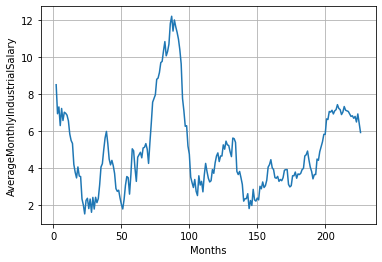

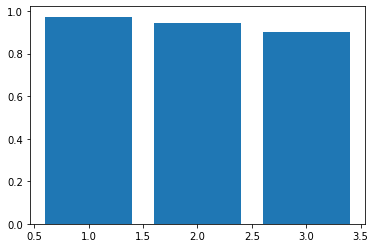

In [ ]:
# график зависимости средней зарплаты на производстве от месяцев + аномалии + автокорреляция
plt.xlabel("Months") # ось абсцисс
plt.ylabel("AverageMonthlyIndustrialSalary") # ось ординат
plt.grid()      # включение отображения сетки
plt.plot(df_poland['Months'],df_poland['AverageMonthlyIndustrialSalary'])
anomaly_check(df_poland['AverageMonthlyIndustrialSalary'])
corr_array = autocorr_lags('AverageMonthlyIndustrialSalary')
print(t_stat(corr_array))

     Months     Irvin  No anomaly
0         0       NaN       False
1         1  0.053418        True
2         2  0.075558        True
3         3  0.048554        True
4         4  0.082931        True
5         5  0.113147        True
6         6  0.093893        True
7         7  0.069155        True
8         8  0.088658        True
9         9  0.136769        True
10       10  0.014398        True
11       11  0.152177        True
12       12  0.015813        True
13       13  0.095065        True
14       14  0.076633        True
15       15  0.025482        True
16       16  0.062713        True
17       17  0.107410        True
18       18  0.055932        True
19       19  0.106187        True
20       20  0.010296        True
21       21  0.151906        True
22       22  0.108313        True
23       23  0.310175        True
24       24  0.662150        True
25       25  0.099048        True
26       26  0.045632        True
27       27  0.104608        True
28       28  0

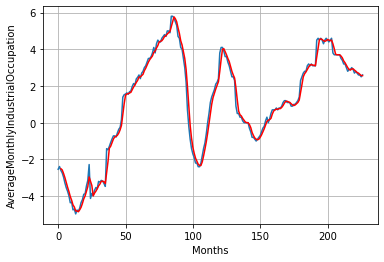

In [ ]:
# график зависимости средней занятости на производстве от месяцев + сглаживание
from math import sqrt
anomaly_check(df_poland['AverageMonthlyIndustrialOccupation'])
smoothed_data=smoothing(df_poland['AverageMonthlyIndustrialOccupation'],'AverageMonthlyIndustrialOccupation')
df_poland['AverageMonthlyIndustrialOccupation']=smoothed_data['AverageMonthlyIndustrialOccupation']

     Months     Irvin  No anomaly
0         0       NaN       False
1         1       NaN       False
2         2       NaN       False
3         3  0.023668        True
4         4  0.069318        True
5         5  0.081903        True
6         6  0.097082        True
7         7  0.092470        True
8         8  0.084271        True
9         9  0.098626        True
10       10  0.070652        True
11       11  0.091918        True
12       12  0.040834        True
13       13  0.077482        True
14       14  0.000877        True
15       15  0.014702        True
16       16  0.038121        True
17       17  0.048426        True
18       18  0.075683        True
19       19  0.090238        True
20       20  0.057724        True
21       21  0.089856        True
22       22  0.090568        True
23       23  0.190967        True
24       24  0.081578        True
25       25  0.084680        True
26       26  0.203803        True
27       27  0.052906        True
28       28  0

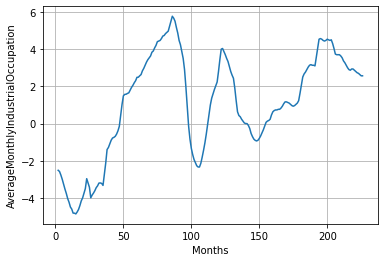

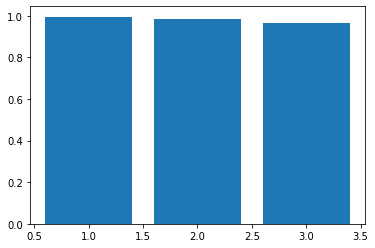

In [ ]:
# график зависимости средней занятости на производстве от месяцев + аномалии + автокорреляция
plt.xlabel("Months") # ось абсцисс
plt.ylabel("AverageMonthlyIndustrialOccupation") # ось ординат
plt.grid()      # включение отображения сетки
plt.plot(df_poland['Months'],df_poland['AverageMonthlyIndustrialOccupation'])
anomaly_check(df_poland['AverageMonthlyIndustrialOccupation'])
corr_array = autocorr_lags('AverageMonthlyIndustrialOccupation')
print(t_stat(corr_array))

     Months     Irvin  No anomaly
0         0       NaN       False
1         1  0.046952        True
2         2  0.046952        True
3         3  0.023476        True
4         4  0.023476        True
5         5  0.000000        True
6         6  0.023476        True
7         7  0.046952        True
8         8  0.023476        True
9         9  0.023476        True
10       10  0.093903        True
11       11  0.164331        True
12       12  0.140855        True
13       13  0.023476        True
14       14  0.000000        True
15       15  0.070428        True
16       16  0.140855        True
17       17  0.023476        True
18       18  0.023476        True
19       19  0.000000        True
20       20  0.023476        True
21       21  0.023476        True
22       22  0.070428        True
23       23  0.046952        True
24       24  0.610373        True
25       25  0.023476        True
26       26  0.023476        True
27       27  0.070428        True
28       28  0

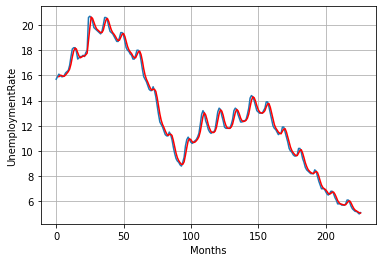

In [ ]:
# график зависимости безработицы от месяцев + сглаживание
from math import sqrt
anomaly_check(df_poland['UnemploymentRate'])
smoothed_data=smoothing(df_poland['UnemploymentRate'],'UnemploymentRate')
df_poland['UnemploymentRate']=smoothed_data['UnemploymentRate']

     Months         Irvin  No anomaly
0         0           NaN       False
1         1           NaN       False
2         2           NaN       False
3         3  2.361846e-02        True
4         4  0.000000e+00        True
5         5  1.574564e-02        True
6         6  0.000000e+00        True
7         7  2.361846e-02        True
8         8  3.149128e-02        True
9         9  3.149128e-02        True
10       10  4.723691e-02        True
11       11  9.447383e-02        True
12       12  1.338379e-01        True
13       13  1.102195e-01        True
14       14  5.510973e-02        True
15       15  1.574564e-02        True
16       16  7.085537e-02        True
17       17  6.298255e-02        True
18       18  3.149128e-02        True
19       19  1.574564e-02        True
20       20  1.574564e-02        True
21       21  0.000000e+00        True
22       22  2.361846e-02        True
23       23  3.149128e-02        True
24       24  2.440574e-01        True
25       25 

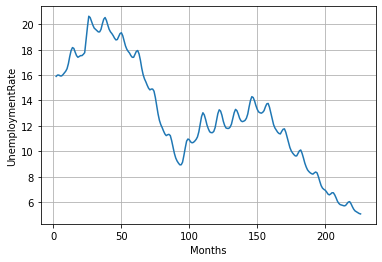

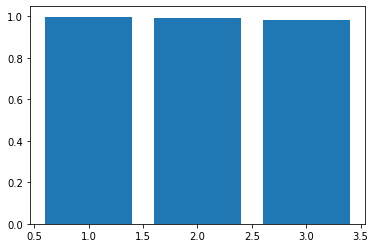

In [ ]:
# график зависимости безработицы от месяцев + аномалии + автокорреляция
plt.xlabel("Months") # ось абсцисс
plt.ylabel("UnemploymentRate") # ось ординат
plt.grid()      # включение отображения сетки
plt.plot(df_poland['Months'],df_poland['UnemploymentRate'])
anomaly_check(df_poland['UnemploymentRate'])
corr_array = autocorr_lags('UnemploymentRate')
print(t_stat(corr_array))

In [ ]:
# Корреляционная матрица (парное сравнение)
df_corr = df_poland.corr()
print(df_corr.round(2))
print(t_stat(df_corr.round(2)))

                                    Months   CPI  \
Months                                1.00 -0.39   
CPI                                  -0.39  1.00   
AverageMonthlyIndustrialSalary        0.04  0.38   
AverageMonthlyIndustrialOccupation    0.56 -0.07   
ProductSales                         -0.17 -0.07   
ProductPrices                        -0.23  0.63   
InflationWithoutProductsAndEnergy    -0.46  0.82   
UnemploymentRate                     -0.87  0.11   

                                    AverageMonthlyIndustrialSalary  \
Months                                                        0.04   
CPI                                                           0.38   
AverageMonthlyIndustrialSalary                                1.00   
AverageMonthlyIndustrialOccupation                            0.54   
ProductSales                                                  0.04   
ProductPrices                                                 0.14   
InflationWithoutProductsAndEnergy        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in sqrt


b0: [2.59445023]
b1: [[-0.00934573]]
R^2: 0.21453739996677512
Коэффициент детерминации статистически значим
predicted response:
[[0.45427812]]
('Шум несмещён, условие выполнено', 'T и крит', 3.976413027711613e-14, 1.970658960834481)
Крит и сумм пиков 136 19
Шумы неслучайны, условие не выполнено
Eсть положительная автокорреляция остатков, Коэффициент автокорреляции (1): 0.9905395564159548
0.018655694164991236
RS [5.19961733]
У шумов не нормальное распределение
Средняя абсолютная ошибка 0.89
Относительная ошибка(%) 342111122588318.3
Относительная ошибка по среднему(%) 56.63
Относительная ошибка по СКО(%) 69.72
Расчёт границ интервала
2.313965584217916
2.314230365118479
2.3144974481977045
Границы
[[-1.85968747]]
[[2.7682437]]
[[-1.85995225]]
[[2.76850848]]
[[-1.86021933]]
[[2.76877557]]


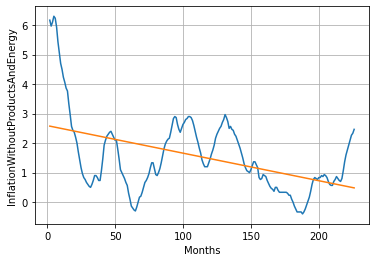

In [ ]:
# линейная регрессия InflationWithoutProductsAndEnergy
from sklearn.linear_model import LinearRegression

df_inf_without_none = df_poland['InflationWithoutProductsAndEnergy'].dropna()
y = np.array(df_inf_without_none.values).reshape(-1, 1)
if (len(y)<len(df_poland['Months'])):
  df_months_new = df_poland['Months'].drop(labels=[0,1])
else:
  df_months_new = df_poland['Months']
X = np.array(df_months_new.values).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y) #R^2
print('b0:', model.intercept_)
print('b1:', model.coef_)
print('R^2:', r_sq)
f_crit(r_sq,1,len(df_months_new))
y_pred = model.predict(X)
y_pred_2 = model.intercept_ + model.coef_ * 229
print('predicted response:', y_pred_2, sep='\n')
df_e = y - y_pred
print(non_biased(df_e))
print(randmonless(df_e))
print(independent_darbin(df_e))
print(normality(df_e))
model_accuracy(df_e,y)
print("Расчёт границ интервала")
k_1 = left_right_edge(227,df_e,1)
k_2 = left_right_edge(227,df_e,2)
k_3 = left_right_edge(227,df_e,3)
print(k_1,k_2,k_3,sep='\n')
print("Границы")
left_1 = y_pred_2 - k_1
right_1 = y_pred_2 + k_1
left_2 = y_pred_2 - k_2
right_2 = y_pred_2 + k_2
left_3 = y_pred_2 - k_3
right_3 = y_pred_2 + k_3
print(left_1,right_1,left_2,right_2,left_3,right_3,sep='\n')
import matplotlib.pyplot as plt
plt.xlabel("Months") # ось абсцисс
plt.ylabel("InflationWithoutProductsAndEnergy") # ось ординат
plt.grid()      # включение отображения сетки
# plot original and transformed dataset
plt.plot(df_months_new,df_inf_without_none)
plt.plot(df_months_new,y_pred)
plt.show()

b0: [3.32107784]
b1: [[-0.01049324]]
R^2: 0.15083038676189164
Коэффициент детерминации статистически значим
predicted response:
[[0.9181267]]
('Шум несмещён, условие выполнено', 'T и крит', 6.590700848622778e-15, 1.970658960834481)
Крит и сумм пиков 136 21
Шумы неслучайны, условие не выполнено
Eсть положительная автокорреляция остатков, Коэффициент автокорреляции (1): 0.9866433677487454
0.02647062812381988
RS [4.0098174]
Шум нормальный, т.е. у шумов нормальное распределение
Средняя абсолютная ошибка 1.41
Относительная ошибка(%) 129.92
Относительная ошибка по среднему(%) 60.9
Относительная ошибка по СКО(%) 94.76
Расчёт границ интервала
3.2217711355502603
3.2221397942150642
3.2225116582398843
Границы
[[-2.30364443]]
[[4.13989784]]
[[-2.30401309]]
[[4.1402665]]
[[-2.30438496]]
[[4.14063836]]


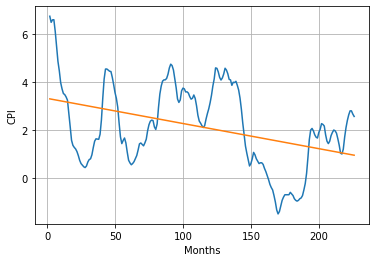

In [ ]:
# линейная регрессия CPI
from sklearn.linear_model import LinearRegression

df_cpi_without_none = df_poland['CPI'].dropna()
y = np.array(df_cpi_without_none.values).reshape(-1, 1)
if (len(y)<len(df_poland['Months'])):
  df_months_new = df_poland['Months'].drop(labels=[0,1])
else:
  df_months_new = df_poland['Months']
X = np.array(df_months_new.values).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y) #R^2
print('b0:', model.intercept_)
print('b1:', model.coef_)
print('R^2:', r_sq)
f_crit(r_sq,1,len(df_months_new))
y_pred = model.predict(X)
y_pred_2 = model.intercept_ + model.coef_ * 229
print('predicted response:', y_pred_2, sep='\n')
df_e = y - y_pred
print(non_biased(df_e))
print(randmonless(df_e))
print(independent_darbin(df_e))
print(normality(df_e))
model_accuracy(df_e,y)
print("Расчёт границ интервала")
k_1 = left_right_edge(227,df_e,1)
k_2 = left_right_edge(227,df_e,2)
k_3 = left_right_edge(227,df_e,3)
print(k_1,k_2,k_3,sep='\n')
print("Границы")
left_1 = y_pred_2 - k_1
right_1 = y_pred_2 + k_1
left_2 = y_pred_2 - k_2
right_2 = y_pred_2 + k_2
left_3 = y_pred_2 - k_3
right_3 = y_pred_2 + k_3
print(left_1,right_1,left_2,right_2,left_3,right_3,sep='\n')
import matplotlib.pyplot as plt
plt.xlabel("Months") # ось абсцисс
plt.ylabel("CPI") # ось ординат
plt.grid()      # включение отображения сетки
# plot original and transformed dataset
plt.plot(df_months_new,df_cpi_without_none)
plt.plot(df_months_new,y_pred)
plt.show()

b0: [7.50817867]
b1: [[-0.01599724]]
R^2: 0.03016415092865521
Коэффициент детерминации статистически значим
predicted response:
[[3.84481037]]
('Шум несмещён, условие выполнено', 'T и крит', 6.633101188768007e-15, 1.970658960834481)
Крит и сумм пиков 136 46
Шумы неслучайны, условие не выполнено
Eсть положительная автокорреляция остатков, Коэффициент автокорреляции (1): 0.9620325168028514
0.07589966974966594
RS [6.44079502]
У шумов не нормальное распределение
Средняя абсолютная ошибка 4.31
Относительная ошибка(%) 247.46
Относительная ошибка по среднему(%) 65.23
Относительная ошибка по СКО(%) 87.06
Расчёт границ интервала
11.737648332781138
11.73899144052537
11.740346226128477
Границы
[[-7.89283796]]
[[15.5824587]]
[[-7.89418107]]
[[15.58380181]]
[[-7.89553586]]
[[15.5851566]]


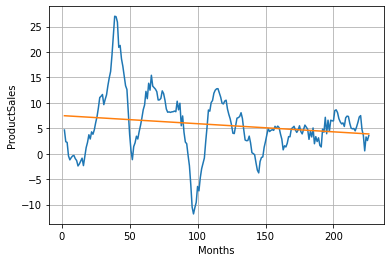

In [ ]:
# линейная регрессия ProductSales
from sklearn.linear_model import LinearRegression

df_prodsales_without_none = df_poland['ProductSales'].dropna()
y = np.array(df_prodsales_without_none.values).reshape(-1, 1)
if (len(y)<len(df_poland['Months'])):
  df_months_new = df_poland['Months'].drop(labels=[0,1])
else:
  df_months_new = df_poland['Months']
X = np.array(df_months_new.values).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y) #R^2
print('b0:', model.intercept_)
print('b1:', model.coef_)
print('R^2:', r_sq)
f_crit(r_sq,1,len(df_months_new))
y_pred = model.predict(X)
y_pred_2 = model.intercept_ + model.coef_ * 229
print('predicted response:', y_pred_2, sep='\n')
df_e = y - y_pred
print(non_biased(df_e))
print(randmonless(df_e))
print(independent_darbin(df_e))
print(normality(df_e))
model_accuracy(df_e,y)
print("Расчёт границ интервала")
k_1 = left_right_edge(227,df_e,1)
k_2 = left_right_edge(227,df_e,2)
k_3 = left_right_edge(227,df_e,3)
print(k_1,k_2,k_3,sep='\n')
print("Границы")
left_1 = y_pred_2 - k_1
right_1 = y_pred_2 + k_1
left_2 = y_pred_2 - k_2
right_2 = y_pred_2 + k_2
left_3 = y_pred_2 - k_3
right_3 = y_pred_2 + k_3
print(left_1,right_1,left_2,right_2,left_3,right_3,sep='\n')
import matplotlib.pyplot as plt
plt.xlabel("Months") # ось абсцисс
plt.ylabel("ProductSales") # ось ординат
plt.grid()      # включение отображения сетки
# plot original and transformed dataset
plt.plot(df_months_new,df_prodsales_without_none)
plt.plot(df_months_new,y_pred)
plt.show()

b0: [3.043902]
b1: [[-0.00966126]]
R^2: 0.05294248878150187
Коэффициент детерминации статистически значим
predicted response:
[[0.83147378]]
('Шум несмещён, условие выполнено', 'T и крит', 3.3465159882342218e-15, 1.970658960834481)
Крит и сумм пиков 136 24
Шумы неслучайны, условие не выполнено
Eсть положительная автокорреляция остатков, Коэффициент автокорреляции (1): 0.9753834004632281
0.04921366240441941
RS [4.16593122]
Шум нормальный, т.е. у шумов нормальное распределение
Средняя абсолютная ошибка 2.12
Относительная ошибка(%) 259.87
Относительная ошибка по среднему(%) 81.08
Относительная ошибка по СКО(%) 101.22
Расчёт границ интервала
5.287521368440499
5.288126405386265
5.2887367029197225
Границы
[[-4.45604759]]
[[6.11899515]]
[[-4.45665263]]
[[6.11960018]]
[[-4.45726292]]
[[6.12021048]]


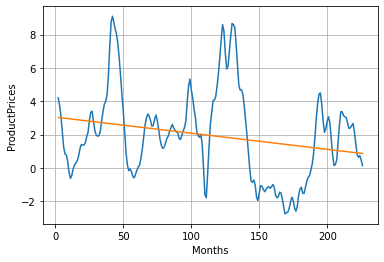

In [ ]:
# линейная регрессия ProductPrices
from sklearn.linear_model import LinearRegression

df_prodprices_without_none = df_poland['ProductPrices'].dropna()
y = np.array(df_prodprices_without_none.values).reshape(-1, 1)
if (len(y)<len(df_poland['Months'])):
  df_months_new = df_poland['Months'].drop(labels=[0,1])
else:
  df_months_new = df_poland['Months']
X = np.array(df_months_new.values).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y) #R^2
print('b0:', model.intercept_)
print('b1:', model.coef_)
print('R^2:', r_sq)
f_crit(r_sq,1,len(df_months_new))
y_pred = model.predict(X)
y_pred_2 = model.intercept_ + model.coef_ * 229
print('predicted response:', y_pred_2, sep='\n')
df_e = y - y_pred
print(non_biased(df_e))
print(randmonless(df_e))
print(independent_darbin(df_e))
print(normality(df_e))
model_accuracy(df_e,y)
print("Расчёт границ интервала")
k_1 = left_right_edge(227,df_e,1)
k_2 = left_right_edge(227,df_e,2)
k_3 = left_right_edge(227,df_e,3)
print(k_1,k_2,k_3,sep='\n')
print("Границы")
left_1 = y_pred_2 - k_1
right_1 = y_pred_2 + k_1
left_2 = y_pred_2 - k_2
right_2 = y_pred_2 + k_2
left_3 = y_pred_2 - k_3
right_3 = y_pred_2 + k_3
print(left_1,right_1,left_2,right_2,left_3,right_3,sep='\n')
import matplotlib.pyplot as plt
plt.xlabel("Months") # ось абсцисс
plt.ylabel("ProductPrices") # ось ординат
plt.grid()      # включение отображения сетки
# plot original and transformed dataset
plt.plot(df_months_new,df_prodprices_without_none)
plt.plot(df_months_new,y_pred)
plt.show()

b0: [4.8029061]
b1: [[0.00139035]]
R^2: 0.0015118243554781419
Коэффициент детерминации статистически не значим
predicted response:
[[5.12129566]]
('Шум несмещён, условие выполнено', 'T и крит', 1.2246682491757804e-14, 1.970658960834481)
Крит и сумм пиков 136 56
Шумы неслучайны, условие не выполнено
Eсть положительная автокорреляция остатков, Коэффициент автокорреляции (1): 0.972925084094199
0.053886525602645
RS [4.55327714]
Шум нормальный, т.е. у шумов нормальное распределение
Средняя абсолютная ошибка 1.83
Относительная ошибка(%) 43.79
Относительная ошибка по среднему(%) 36.83
Относительная ошибка по СКО(%) 78.67
Расчёт границ интервала
4.6235606573845764
4.624089719079798
4.6246233807840955
Границы
[[0.497735]]
[[9.74485632]]
[[0.49720594]]
[[9.74538538]]
[[0.49667228]]
[[9.74591904]]


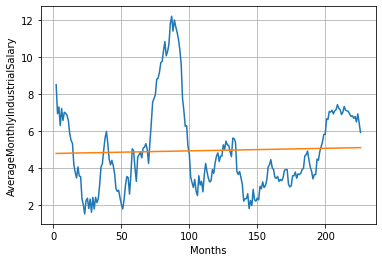

In [ ]:
# линейная регрессия AverageMonthlyIndustrialSalary
from sklearn.linear_model import LinearRegression

df_avgmonindsal_without_none = df_poland['AverageMonthlyIndustrialSalary'].dropna()
y = np.array(df_avgmonindsal_without_none.values).reshape(-1, 1)
if (len(y)<len(df_poland['Months'])):
  df_months_new = df_poland['Months'].drop(labels=[0,1])
else:
  df_months_new = df_poland['Months']
X = np.array(df_months_new.values).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y) #R^2
print('b0:', model.intercept_)
print('b1:', model.coef_)
print('R^2:', r_sq)
f_crit(r_sq,1,len(df_months_new))
y_pred = model.predict(X)
y_pred_2 = model.intercept_ + model.coef_ * 229
print('predicted response:', y_pred_2, sep='\n')
df_e = y - y_pred
print(non_biased(df_e))
print(randmonless(df_e))
print(independent_darbin(df_e))
print(normality(df_e))
model_accuracy(df_e,y)
print("Расчёт границ интервала")
k_1 = left_right_edge(227,df_e,1)
k_2 = left_right_edge(227,df_e,2)
k_3 = left_right_edge(227,df_e,3)
print(k_1,k_2,k_3,sep='\n')
print("Границы")
left_1 = y_pred_2 - k_1
right_1 = y_pred_2 + k_1
left_2 = y_pred_2 - k_2
right_2 = y_pred_2 + k_2
left_3 = y_pred_2 - k_3
right_3 = y_pred_2 + k_3
print(left_1,right_1,left_2,right_2,left_3,right_3,sep='\n')
import matplotlib.pyplot as plt
plt.xlabel("Months") # ось абсцисс
plt.ylabel("AverageMonthlyIndustrialSalary") # ось ординат
plt.grid()      # включение отображения сетки
# plot original and transformed dataset
plt.plot(df_months_new,df_avgmonindsal_without_none)
plt.plot(df_months_new,y_pred)
plt.show()

b0: [-1.6525742]
b1: [[0.02368725]]
R^2: 0.3080511129524026
Коэффициент детерминации статистически значим
predicted response:
[[3.77180628]]
('Шум несмещён, условие выполнено', 'T и крит', 1.2326004170057501e-14, 1.970658960834481)
Крит и сумм пиков 136 14
Шумы неслучайны, условие не выполнено
Eсть положительная автокорреляция остатков, Коэффициент автокорреляции (1): 0.9932079576416846
0.013572328305671772
RS [3.87628755]
Шум нормальный, т.е. у шумов нормальное распределение
Средняя абсолютная ошибка 1.94
Относительная ошибка(%) inf
Относительная ошибка по среднему(%) 75.89
Относительная ошибка по СКО(%) 128.39
Расчёт границ интервала
4.593806603596805
4.594332260615133
4.594862488040045
Границы
[[-0.82200032]]
[[8.36561288]]
[[-0.82252598]]
[[8.36613854]]
[[-0.82305621]]
[[8.36666877]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in true_divide


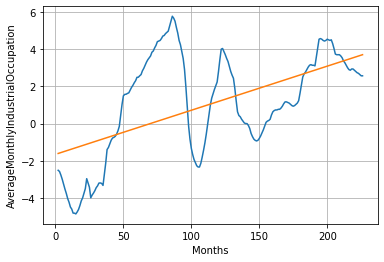

In [ ]:
# линейная регрессия AverageMonthlyIndustrialOccupation
from sklearn.linear_model import LinearRegression

df_avgmonindocc_without_none = df_poland['AverageMonthlyIndustrialOccupation'].dropna()
y = np.array(df_avgmonindocc_without_none.values).reshape(-1, 1)
if (len(y)<len(df_poland['Months'])):
  df_months_new = df_poland['Months'].drop(labels=[0,1])
else:
  df_months_new = df_poland['Months']
X = np.array(df_months_new.values).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y) #R^2
print('b0:', model.intercept_)
print('b1:', model.coef_)
print('R^2:', r_sq)
f_crit(r_sq,1,len(df_months_new))
y_pred = model.predict(X)
y_pred_2 = model.intercept_ + model.coef_ * 229
print('predicted response:', y_pred_2, sep='\n')
df_e = y - y_pred
print(non_biased(df_e))
print(randmonless(df_e))
print(independent_darbin(df_e))
print(normality(df_e))
model_accuracy(df_e,y)
print("Расчёт границ интервала")
k_1 = left_right_edge(227,df_e,1)
k_2 = left_right_edge(227,df_e,2)
k_3 = left_right_edge(227,df_e,3)
print(k_1,k_2,k_3,sep='\n')
print("Границы")
left_1 = y_pred_2 - k_1
right_1 = y_pred_2 + k_1
left_2 = y_pred_2 - k_2
right_2 = y_pred_2 + k_2
left_3 = y_pred_2 - k_3
right_3 = y_pred_2 + k_3
print(left_1,right_1,left_2,right_2,left_3,right_3,sep='\n')
import matplotlib.pyplot as plt
plt.xlabel("Months") # ось абсцисс
plt.ylabel("AverageMonthlyIndustrialOccupation") # ось ординат
plt.grid()      # включение отображения сетки
# plot original and transformed dataset
plt.plot(df_months_new,df_avgmonindocc_without_none)
plt.plot(df_months_new,y_pred)
plt.show()

b0: [19.30784413]
b1: [[-0.05687323]]
R^2: 0.7645897851937062
Коэффициент детерминации статистически значим
predicted response:
[[6.28387524]]
('Шум несмещён, условие выполнено', 'T и крит', 2.4265786065137345e-14, 1.970658960834481)
Крит и сумм пиков 136 19
Шумы неслучайны, условие не выполнено
Eсть положительная автокорреляция остатков, Коэффициент автокорреляции (1): 0.9903713222118637
0.0191662105176949
RS [4.16159574]
Шум нормальный, т.е. у шумов нормальное распределение
Средняя абсолютная ошибка 1.7
Относительная ошибка(%) 14.34
Относительная ошибка по среднему(%) 13.24
Относительная ошибка по СКО(%) 40.19
Расчёт границ интервала
4.0835577549665505
4.084025025572145
4.08449635893459
Границы
[[2.20031749]]
[[10.36743299]]
[[2.19985021]]
[[10.36790027]]
[[2.19937888]]
[[10.3683716]]


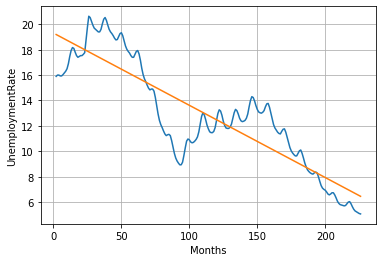

In [ ]:
# линейная регрессия UnemploymentRate
from sklearn.linear_model import LinearRegression

df_unemployment_without_none = df_poland['UnemploymentRate'].dropna()
y = np.array(df_unemployment_without_none.values).reshape(-1, 1)
if (len(y)<len(df_poland['Months'])):
  df_months_new = df_poland['Months'].drop(labels=[0,1])
else:
  df_months_new = df_poland['Months']
X = np.array(df_months_new.values).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y) #R^2
print('b0:', model.intercept_)
print('b1:', model.coef_)
print('R^2:', r_sq)
f_crit(r_sq,1,len(df_months_new))
y_pred = model.predict(X)
y_pred_2 = model.intercept_ + model.coef_ * 229
print('predicted response:', y_pred_2, sep='\n')
df_e = y - y_pred
print(non_biased(df_e))
print(randmonless(df_e))
print(independent_darbin(df_e))
print(normality(df_e))
model_accuracy(df_e,y)
print("Расчёт границ интервала")
k_1 = left_right_edge(227,df_e,1)
k_2 = left_right_edge(227,df_e,2)
k_3 = left_right_edge(227,df_e,3)
print(k_1,k_2,k_3,sep='\n')
print("Границы")
left_1 = y_pred_2 - k_1
right_1 = y_pred_2 + k_1
left_2 = y_pred_2 - k_2
right_2 = y_pred_2 + k_2
left_3 = y_pred_2 - k_3
right_3 = y_pred_2 + k_3
print(left_1,right_1,left_2,right_2,left_3,right_3,sep='\n')
import matplotlib.pyplot as plt
plt.xlabel("Months") # ось абсцисс
plt.ylabel("UnemploymentRate") # ось ординат
plt.grid()      # включение отображения сетки
# plot original and transformed dataset
plt.plot(df_months_new,df_unemployment_without_none)
plt.plot(df_months_new,y_pred)
plt.show()

a1, b1 6.013333333333333 0.04666666666666614
Предсказанное 6.059999999999999
Прогнозные значения:
[2.6332914663977722, 2.7792239934613483, 2.925156520524925]
Шум смещён, условие не выполнено
Крит и сумм пиков 136 40
Шумы неслучайны, условие не выполнено
Eсть положительная автокорреляция остатков, Коэффициент автокорреляции (1): 0.8547497047143264
0.29021707119808166
RS 5.964808285109983
У шумов не нормальное распределение
Средняя абсолютная ошибка 0.18
Относительная ошибка(%) 68157415853136.72
Относительная ошибка по среднему(%) 11.39
Относительная ошибка по СКО(%) 14.02
Расчёт границ интервала
0.4535020389832905
0.4535539320101826
0.45360627622905636
Границы
2.1797894274144816
3.086793505381063
2.3256700614511656
3.232777925471531
2.4715502442958686
3.378762796753981


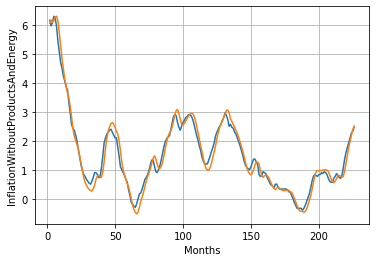

In [ ]:
# Браун InflationWithoutProductsAndEnergy
from sklearn.linear_model import LinearRegression

df_inf_without_none = df_poland['InflationWithoutProductsAndEnergy'].dropna()
df_inf_without_none_5 = df_inf_without_none.iloc[0:5]
y = np.array(df_inf_without_none_5.values).reshape(-1, 1)
if (len(y)<len(df_poland['Months'])):
  df_months_new = df_poland['Months'].drop(labels=[0,1])
else:
  df_months_new = df_poland['Months']
df_months_new_5 = df_months_new.iloc[0:5]
df_months = np.asarray([1,2,3,4,5])
X = np.array(df_months).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y) #R^2
a = model.intercept_.ravel()
a = [float(item) for item in a]
b = model.coef_.ravel()
b = [float(item) for item in b]
a1=a[0]
b1=b[0]
print('a1, b1',a1,b1)
y_pred_arr = []
df_e = []
for i in range(2,len(df_inf_without_none)+2):
  y_pred = a1+b1
  y_pred_arr.append(y_pred)
  e = df_inf_without_none[i] - y_pred 
  df_e.append(e)
  a1 = a1 + b1 + (1-0.7**2)*e
  b1 = b1 + ((1-0.7)**2)*e
print("Предсказанное",y_pred_arr[0])
print('Прогнозные значения:')
y_pred_pred = []
for i in range(1,4):
  y_pred_3 = a1 + b1*i
  y_pred_pred.append(y_pred_3)
print(y_pred_pred)
df_e = np.asarray(df_e)
y_pred_arr = np.asarray(y_pred_arr)
print(non_biased(df_e))
print(randmonless(df_e))
print(independent_darbin(df_e))
print(normality(df_e))
model_accuracy(df_e,df_inf_without_none)
print("Расчёт границ интервала")
k_1 = left_right_edge(227,df_e,1)
k_2 = left_right_edge(228,df_e,2)
k_3 = left_right_edge(229,df_e,3)
print(k_1,k_2,k_3,sep='\n')
print("Границы")
left_1 = y_pred_pred[0] - k_1
right_1 = y_pred_pred[0] + k_1
left_2 = y_pred_pred[1] - k_2
right_2 = y_pred_pred[1] + k_2
left_3 = y_pred_pred[2] - k_3
right_3 = y_pred_pred[2] + k_3
print(left_1,right_1,left_2,right_2,left_3,right_3,sep='\n')
import matplotlib.pyplot as plt
plt.xlabel("Months") # ось абсцисс
plt.ylabel("InflationWithoutProductsAndEnergy") # ось ординат
plt.grid()      # включение отображения сетки
# plot original and transformed dataset
plt.plot(df_months_new,df_inf_without_none)
plt.plot(df_months_new,y_pred_arr)
plt.show()

a1, b1 6.857899999999999 -0.11550000000000009
Предсказанное 6.742399999999999
Прогнозные значения:
[2.8510392578959065, 2.9470043588663084, 3.0429694598367103]
Шум смещён, условие не выполнено
Крит и сумм пиков 136 32
Шумы неслучайны, условие не выполнено
Eсть положительная автокорреляция остатков, Коэффициент автокорреляции (1): 0.8447401934266291
0.3096356495933141
RS 4.839542845821384
Шум нормальный, т.е. у шумов нормальное распределение
Средняя абсолютная ошибка 0.32
Относительная ошибка(%) 22.45
Относительная ошибка по среднему(%) 13.61
Относительная ошибка по СКО(%) 21.18
Расчёт границ интервала
0.7881202273652449
0.7882104098575763
0.7883013764555933
Границы
2.0629190305306615
3.6391594852611515
2.1587939490087322
3.7352147687238846
2.254668083381117
3.831270836292304


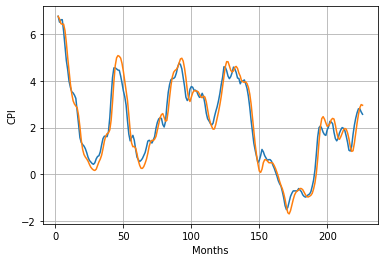

In [ ]:
# Браун CPI
from sklearn.linear_model import LinearRegression

df_cpi_without_none = df_poland['CPI'].dropna()
df_cpi_without_none_5 = df_cpi_without_none.iloc[0:5]
y = np.array(df_cpi_without_none_5.values).reshape(-1, 1)
if (len(y)<len(df_poland['Months'])):
  df_months_new = df_poland['Months'].drop(labels=[0,1])
else:
  df_months_new = df_poland['Months']
df_months_new_5 = df_months_new.iloc[0:5]
df_months = np.asarray([1,2,3,4,5])
X = np.array(df_months).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y) #R^2
a = model.intercept_.ravel()
a = [float(item) for item in a]
b = model.coef_.ravel()
b = [float(item) for item in b]
a1=a[0]
b1=b[0]
print('a1, b1',a1,b1)
y_pred_arr = []
df_e = []
for i in range(2,len(df_cpi_without_none)+2):
  y_pred = a1+b1
  y_pred_arr.append(y_pred)
  e = df_cpi_without_none[i] - y_pred 
  df_e.append(e)
  a1 = a1 + b1 + (1-0.7**2)*e
  b1 = b1 + ((1-0.7)**2)*e
print("Предсказанное",y_pred_arr[0])
print('Прогнозные значения:')
y_pred_pred = []
for i in range(1,4):
  y_pred_3 = a1 + b1*i
  y_pred_pred.append(y_pred_3)
print(y_pred_pred)
df_e = np.asarray(df_e)
y_pred_arr = np.asarray(y_pred_arr)
print(non_biased(df_e))
print(randmonless(df_e))
print(independent_darbin(df_e))
print(normality(df_e))
model_accuracy(df_e,df_cpi_without_none)
print("Расчёт границ интервала")
k_1 = left_right_edge(227,df_e,1)
k_2 = left_right_edge(228,df_e,2)
k_3 = left_right_edge(229,df_e,3)
print(k_1,k_2,k_3,sep='\n')
print("Границы")
left_1 = y_pred_pred[0] - k_1
right_1 = y_pred_pred[0] + k_1
left_2 = y_pred_pred[1] - k_2
right_2 = y_pred_pred[1] + k_2
left_3 = y_pred_pred[2] - k_3
right_3 = y_pred_pred[2] + k_3
print(left_1,right_1,left_2,right_2,left_3,right_3,sep='\n')
import matplotlib.pyplot as plt
plt.xlabel("Months") # ось абсцисс
plt.ylabel("CPI") # ось ординат
plt.grid()      # включение отображения сетки
# plot original and transformed dataset
plt.plot(df_months_new,df_cpi_without_none)
plt.plot(df_months_new,y_pred_arr)
plt.show()

a1, b1 5.8866666666666685 -1.4533333333333338
Предсказанное 4.4333333333333345
Прогнозные значения:
[2.525244588018086, 2.255965676735589, 1.9866867654530926]
Шум смещён, условие не выполнено
Крит и сумм пиков 136 57
Шумы неслучайны, условие не выполнено
Eсть положительная автокорреляция остатков, Коэффициент автокорреляции (1): 0.6770049480650445
0.6448326786871343
RS 6.709898576172617
У шумов не нормальное распределение
Средняя абсолютная ошибка 1.72
Относительная ошибка(%) 67.4
Относительная ошибка по среднему(%) 26.11
Относительная ошибка по СКО(%) 34.85
Расчёт границ интервала
4.355933843706373
4.35643228158021
4.356935053199552
Границы
-1.8306892556882866
6.881178431724459
-2.1004666048446206
6.612397958315799
-2.3702482877464597
6.343621818652645


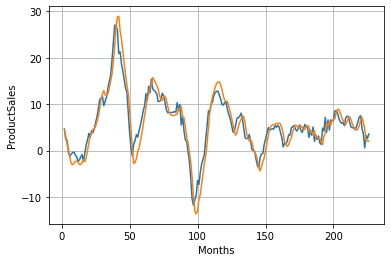

In [ ]:
# Браун ProductSales
from sklearn.linear_model import LinearRegression

df_ps_without_none = df_poland['ProductSales'].dropna()
df_ps_without_none_5 = df_ps_without_none.iloc[0:5]
y = np.array(df_ps_without_none_5.values).reshape(-1, 1)
if (len(y)<len(df_poland['Months'])):
  df_months_new = df_poland['Months'].drop(labels=[0,1])
else:
  df_months_new = df_poland['Months']
df_months_new_5 = df_months_new.iloc[0:5]
df_months = np.asarray([1,2,3,4,5])
X = np.array(df_months).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y) #R^2
a = model.intercept_.ravel()
a = [float(item) for item in a]
b = model.coef_.ravel()
b = [float(item) for item in b]
a1=a[0]
b1=b[0]
print('a1, b1',a1,b1)
y_pred_arr = []
df_e = []
for i in range(2,len(df_ps_without_none)+2):
  y_pred = a1+b1
  y_pred_arr.append(y_pred)
  e = df_ps_without_none[i] - y_pred 
  df_e.append(e)
  a1 = a1 + b1 + (1-0.7**2)*e
  b1 = b1 + ((1-0.7)**2)*e
print("Предсказанное",y_pred_arr[0])
print('Прогнозные значения:')
y_pred_pred = []
for i in range(1,4):
  y_pred_3 = a1 + b1*i
  y_pred_pred.append(y_pred_3)
print(y_pred_pred)
df_e = np.asarray(df_e)
y_pred_arr = np.asarray(y_pred_arr)
print(non_biased(df_e))
print(randmonless(df_e))
print(independent_darbin(df_e))
print(normality(df_e))
model_accuracy(df_e,df_ps_without_none)
print("Расчёт границ интервала")
k_1 = left_right_edge(227,df_e,1)
k_2 = left_right_edge(228,df_e,2)
k_3 = left_right_edge(229,df_e,3)
print(k_1,k_2,k_3,sep='\n')
print("Границы")
left_1 = y_pred_pred[0] - k_1
right_1 = y_pred_pred[0] + k_1
left_2 = y_pred_pred[1] - k_2
right_2 = y_pred_pred[1] + k_2
left_3 = y_pred_pred[2] - k_3
right_3 = y_pred_pred[2] + k_3
print(left_1,right_1,left_2,right_2,left_3,right_3,sep='\n')
import matplotlib.pyplot as plt
plt.xlabel("Months") # ось абсцисс
plt.ylabel("ProductSales") # ось ординат
plt.grid()      # включение отображения сетки
# plot original and transformed dataset
plt.plot(df_months_new,df_ps_without_none)
plt.plot(df_months_new,y_pred_arr)
plt.show()

a1, b1 5.15 -0.7433333333333332
Предсказанное 4.406666666666667
Прогнозные значения:
[-0.0619016344425764, -0.3009531626319792, -0.540004690821382]
Шум смещён, условие не выполнено
Крит и сумм пиков 136 34
Шумы неслучайны, условие не выполнено
Eсть положительная автокорреляция остатков, Коэффициент автокорреляции (1): 0.8329531598989125
0.3337971490306768
RS 5.871480984081703
У шумов не нормальное распределение
Средняя абсолютная ошибка 0.72
Относительная ошибка(%) 102.29
Относительная ошибка по среднему(%) 27.72
Относительная ошибка по СКО(%) 34.61
Расчёт границ интервала
1.8534276776765755
1.8536397604547166
1.8538536872195102
Границы
-1.915329312119152
1.791526043233999
-2.1545929230866956
1.5526865978227373
-2.393858378040892
1.3138489963981281


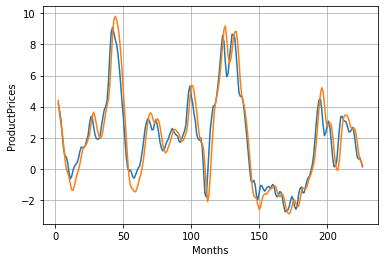

In [ ]:
# Браун ProductPrices
from sklearn.linear_model import LinearRegression

df_ppr_without_none = df_poland['ProductPrices'].dropna()
df_ppr_without_none_5 = df_ppr_without_none.iloc[0:5]
y = np.array(df_ppr_without_none_5.values).reshape(-1, 1)
if (len(y)<len(df_poland['Months'])):
  df_months_new = df_poland['Months'].drop(labels=[0,1])
else:
  df_months_new = df_poland['Months']
df_months_new_5 = df_months_new.iloc[0:5]
df_months = np.asarray([1,2,3,4,5])
X = np.array(df_months).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y) #R^2
a = model.intercept_.ravel()
a = [float(item) for item in a]
b = model.coef_.ravel()
b = [float(item) for item in b]
a1=a[0]
b1=b[0]
print('a1, b1',a1,b1)
y_pred_arr = []
df_e = []
for i in range(2,len(df_ppr_without_none)+2):
  y_pred = a1+b1
  y_pred_arr.append(y_pred)
  e = df_ppr_without_none[i] - y_pred 
  df_e.append(e)
  a1 = a1 + b1 + (1-0.7**2)*e
  b1 = b1 + ((1-0.7)**2)*e
print("Предсказанное",y_pred_arr[0])
print('Прогнозные значения:')
y_pred_pred = []
for i in range(1,4):
  y_pred_3 = a1 + b1*i
  y_pred_pred.append(y_pred_3)
print(y_pred_pred)
df_e = np.asarray(df_e)
y_pred_arr = np.asarray(y_pred_arr)
print(non_biased(df_e))
print(randmonless(df_e))
print(independent_darbin(df_e))
print(normality(df_e))
model_accuracy(df_e,df_ppr_without_none)
print("Расчёт границ интервала")
k_1 = left_right_edge(227,df_e,1)
k_2 = left_right_edge(228,df_e,2)
k_3 = left_right_edge(229,df_e,3)
print(k_1,k_2,k_3,sep='\n')
print("Границы")
left_1 = y_pred_pred[0] - k_1
right_1 = y_pred_pred[0] + k_1
left_2 = y_pred_pred[1] - k_2
right_2 = y_pred_pred[1] + k_2
left_3 = y_pred_pred[2] - k_3
right_3 = y_pred_pred[2] + k_3
print(left_1,right_1,left_2,right_2,left_3,right_3,sep='\n')
import matplotlib.pyplot as plt
plt.xlabel("Months") # ось абсцисс
plt.ylabel("ProductPrices") # ось ординат
plt.grid()      # включение отображения сетки
# plot original and transformed dataset
plt.plot(df_months_new,df_ppr_without_none)
plt.plot(df_months_new,y_pred_arr)
plt.show()

a1, b1 8.219401313666665 -0.3198616670666665
Предсказанное 7.899539646599999
Прогнозные значения:
[6.12092420661661, 6.01839780354212, 5.915871400467632]
Шум смещён, условие не выполнено
Крит и сумм пиков 136 66
Шумы неслучайны, условие не выполнено
Eсть положительная автокорреляция остатков, Коэффициент автокорреляции (1): 0.5012955558035731
0.9930958062693872
RS 6.451132450843321
У шумов не нормальное распределение
Средняя абсолютная ошибка 0.48
Относительная ошибка(%) 11.51
Относительная ошибка по среднему(%) 9.7
Относительная ошибка по СКО(%) 20.73
Расчёт границ интервала
1.2475195258804803
1.247662276207359
1.2478062676991246
Границы
4.8734046807361295
7.36844373249709
4.770735527334761
7.266060079749479
4.668065132768507
7.163677668166756


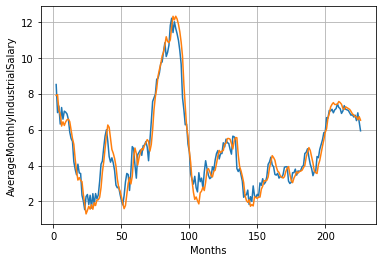

In [ ]:
# Браун AverageMonthlyIndustrialSalary
from sklearn.linear_model import LinearRegression

df_amis_without_none = df_poland['AverageMonthlyIndustrialSalary'].dropna()
df_amis_without_none_5 = df_amis_without_none.iloc[0:5]
y = np.array(df_amis_without_none_5.values).reshape(-1, 1)
if (len(y)<len(df_poland['Months'])):
  df_months_new = df_poland['Months'].drop(labels=[0,1])
else:
  df_months_new = df_poland['Months']
df_months_new_5 = df_months_new.iloc[0:5]
df_months = np.asarray([1,2,3,4,5])
X = np.array(df_months).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y) #R^2
a = model.intercept_.ravel()
a = [float(item) for item in a]
b = model.coef_.ravel()
b = [float(item) for item in b]
a1=a[0]
b1=b[0]
print('a1, b1',a1,b1)
y_pred_arr = []
df_e = []
for i in range(2,len(df_amis_without_none)+2):
  y_pred = a1+b1
  y_pred_arr.append(y_pred)
  e = df_amis_without_none[i] - y_pred 
  df_e.append(e)
  a1 = a1 + b1 + (1-0.7**2)*e
  b1 = b1 + ((1-0.7)**2)*e
print("Предсказанное",y_pred_arr[0])
print('Прогнозные значения:')
y_pred_pred = []
for i in range(1,4):
  y_pred_3 = a1 + b1*i
  y_pred_pred.append(y_pred_3)
print(y_pred_pred)
df_e = np.asarray(df_e)
y_pred_arr = np.asarray(y_pred_arr)
print(non_biased(df_e))
print(randmonless(df_e))
print(independent_darbin(df_e))
print(normality(df_e))
model_accuracy(df_e,df_amis_without_none)
print("Расчёт границ интервала")
k_1 = left_right_edge(227,df_e,1)
k_2 = left_right_edge(228,df_e,2)
k_3 = left_right_edge(229,df_e,3)
print(k_1,k_2,k_3,sep='\n')
print("Границы")
left_1 = y_pred_pred[0] - k_1
right_1 = y_pred_pred[0] + k_1
left_2 = y_pred_pred[1] - k_2
right_2 = y_pred_pred[1] + k_2
left_3 = y_pred_pred[2] - k_3
right_3 = y_pred_pred[2] + k_3
print(left_1,right_1,left_2,right_2,left_3,right_3,sep='\n')
import matplotlib.pyplot as plt
plt.xlabel("Months") # ось абсцисс
plt.ylabel("AverageMonthlyIndustrialSalary") # ось ординат
plt.grid()      # включение отображения сетки
# plot original and transformed dataset
plt.plot(df_months_new,df_amis_without_none)
plt.plot(df_months_new,y_pred_arr)
plt.show()

a1, b1 -2.2427029316000002 -0.19312717086666648
Предсказанное -2.435830102466667
Прогнозные значения:
[2.493284368399103, 2.4431474660902417, 2.39301056378138]
Шум смещён, условие не выполнено
Крит и сумм пиков 136 35
Шумы неслучайны, условие не выполнено
Eсть положительная автокорреляция остатков, Коэффициент автокорреляции (1): 0.8849768848649013
0.22994305180587088
RS 5.776894967282062
У шумов не нормальное распределение
Средняя абсолютная ошибка 0.28
Относительная ошибка(%) inf
Относительная ошибка по среднему(%) 10.91
Относительная ошибка по СКО(%) 18.46
Расчёт границ интервала
0.7677288378973435
0.7678166870574491
0.7679053000357208
Границы
1.7255555305017594
3.2610132062964463
1.6753307790327927
3.2109641531476907
1.6251052637456593
3.1609158638171007


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in true_divide


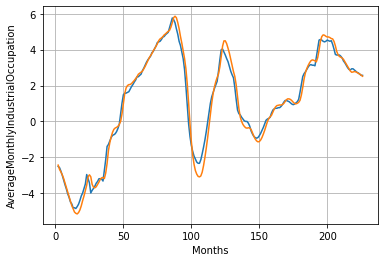

In [ ]:
# Браун AverageMonthlyIndustrialOccupation
from sklearn.linear_model import LinearRegression

df_amio_without_none = df_poland['AverageMonthlyIndustrialOccupation'].dropna()
df_amio_without_none_5 = df_amio_without_none.iloc[0:5]
y = np.array(df_amio_without_none_5.values).reshape(-1, 1)
if (len(y)<len(df_poland['Months'])):
  df_months_new = df_poland['Months'].drop(labels=[0,1])
else:
  df_months_new = df_poland['Months']
df_months_new_5 = df_months_new.iloc[0:5]
df_months = np.asarray([1,2,3,4,5])
X = np.array(df_months).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y) #R^2
a = model.intercept_.ravel()
a = [float(item) for item in a]
b = model.coef_.ravel()
b = [float(item) for item in b]
a1=a[0]
b1=b[0]
print('a1, b1',a1,b1)
y_pred_arr = []
df_e = []
for i in range(2,len(df_amio_without_none)+2):
  y_pred = a1+b1
  y_pred_arr.append(y_pred)
  e = df_amio_without_none[i] - y_pred 
  df_e.append(e)
  a1 = a1 + b1 + (1-0.7**2)*e
  b1 = b1 + ((1-0.7)**2)*e
print("Предсказанное",y_pred_arr[0])
print('Прогнозные значения:')
y_pred_pred = []
for i in range(1,4):
  y_pred_3 = a1 + b1*i
  y_pred_pred.append(y_pred_3)
print(y_pred_pred)
df_e = np.asarray(df_e)
y_pred_arr = np.asarray(y_pred_arr)
print(non_biased(df_e))
print(randmonless(df_e))
print(independent_darbin(df_e))
print(normality(df_e))
model_accuracy(df_e,df_amio_without_none)
print("Расчёт границ интервала")
k_1 = left_right_edge(227,df_e,1)
k_2 = left_right_edge(228,df_e,2)
k_3 = left_right_edge(229,df_e,3)
print(k_1,k_2,k_3,sep='\n')
print("Границы")
left_1 = y_pred_pred[0] - k_1
right_1 = y_pred_pred[0] + k_1
left_2 = y_pred_pred[1] - k_2
right_2 = y_pred_pred[1] + k_2
left_3 = y_pred_pred[2] - k_3
right_3 = y_pred_pred[2] + k_3
print(left_1,right_1,left_2,right_2,left_3,right_3,sep='\n')
import matplotlib.pyplot as plt
plt.xlabel("Months") # ось абсцисс
plt.ylabel("AverageMonthlyIndustrialOccupation") # ось ординат
plt.grid()      # включение отображения сетки
# plot original and transformed dataset
plt.plot(df_months_new,df_amio_without_none)
plt.plot(df_months_new,y_pred_arr)
plt.show()

a1, b1 15.953333333333335 -5.288192912043656e-16
Предсказанное 15.953333333333335
Прогнозные значения:
[4.956242140803077, 4.874001536475879, 4.791760932148679]
Шум смещён, условие не выполнено
Крит и сумм пиков 136 20
Шумы неслучайны, условие не выполнено
Eсть положительная автокорреляция остатков, Коэффициент автокорреляции (1): 0.8345011330049226
0.3309495839307072
RS 5.226151972362053
У шумов не нормальное распределение
Средняя абсолютная ошибка 0.36
Относительная ошибка(%) 2.89
Относительная ошибка по среднему(%) 2.79
Относительная ошибка по СКО(%) 8.48
Расчёт границ интервала
0.8992950523569191
0.8993979562874957
0.8995017549322785
Границы
4.056947088446158
5.855537193159996
3.974603580188383
5.7733994927633745
3.892259177216401
5.6912626870809575


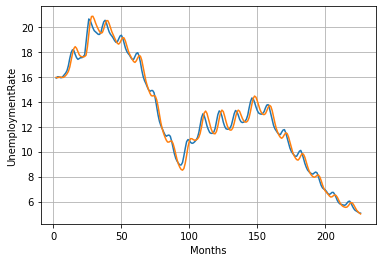

In [ ]:
# Браун UnemploymentRate
from sklearn.linear_model import LinearRegression

df_unemp_without_none = df_poland['UnemploymentRate'].dropna()
df_unemp_without_none_5 = df_unemp_without_none.iloc[0:5]
y = np.array(df_unemp_without_none_5.values).reshape(-1, 1)
if (len(y)<len(df_poland['Months'])):
  df_months_new = df_poland['Months'].drop(labels=[0,1])
else:
  df_months_new = df_poland['Months']
df_months_new_5 = df_months_new.iloc[0:5]
df_months = np.asarray([1,2,3,4,5])
X = np.array(df_months).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y) #R^2
a = model.intercept_.ravel()
a = [float(item) for item in a]
b = model.coef_.ravel()
b = [float(item) for item in b]
a1=a[0]
b1=b[0]
print('a1, b1',a1,b1)
y_pred_arr = []
df_e = []
for i in range(2,len(df_unemp_without_none)+2):
  y_pred = a1+b1
  y_pred_arr.append(y_pred)
  e = df_unemp_without_none[i] - y_pred 
  df_e.append(e)
  a1 = a1 + b1 + (1-0.7**2)*e
  b1 = b1 + ((1-0.7)**2)*e
print("Предсказанное",y_pred_arr[0])
print('Прогнозные значения:')
y_pred_pred = []
for i in range(1,4):
  y_pred_3 = a1 + b1*i
  y_pred_pred.append(y_pred_3)
print(y_pred_pred)
df_e = np.asarray(df_e)
y_pred_arr = np.asarray(y_pred_arr)
print(non_biased(df_e))
print(randmonless(df_e))
print(independent_darbin(df_e))
print(normality(df_e))
model_accuracy(df_e,df_unemp_without_none)
print("Расчёт границ интервала")
k_1 = left_right_edge(227,df_e,1)
k_2 = left_right_edge(227,df_e,2)
k_3 = left_right_edge(227,df_e,3)
print(k_1,k_2,k_3,sep='\n')
print("Границы")
left_1 = y_pred_pred[0] - k_1
right_1 = y_pred_pred[0] + k_1
left_2 = y_pred_pred[1] - k_2
right_2 = y_pred_pred[1] + k_2
left_3 = y_pred_pred[2] - k_3
right_3 = y_pred_pred[2] + k_3
print(left_1,right_1,left_2,right_2,left_3,right_3,sep='\n')
import matplotlib.pyplot as plt
plt.xlabel("Months") # ось абсцисс
plt.ylabel("UnemploymentRate") # ось ординат
plt.grid()      # включение отображения сетки
# plot original and transformed dataset
plt.plot(df_months_new,df_unemp_without_none)
plt.plot(df_months_new,y_pred_arr)
plt.show()